In [1]:
from datasets import load_dataset, DatasetDict
from datasets import Dataset 

import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from transformers import TFAutoModel, AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import TFAutoModelForSequenceClassification

import time
import pickle
import os

In [2]:
def spickluj(df, file_path):
    try:
        pickle.dump(df, open(file_path, "wb"))
        print("Zapisano pomyślnie!")
    except Exception as e:
        print(f"Błąd przy zapisie: {e}")
    # upewnij sie :)
    if os.path.exists(file_path):
        print(f"Plik istnieje! Rozmiar: {os.path.getsize(file_path)} bajtów")
    else:
        print("Plik nie istnieje!")

def odpickluj(df, file_path):
    with open(file_path,'rb') as f:
        df = pickle.load(f)

In [3]:
# Load dataset
df = pd.read_csv("tripadvisor_hotel_reviews.csv.zip", compression='zip')
df.shape[0]

20491

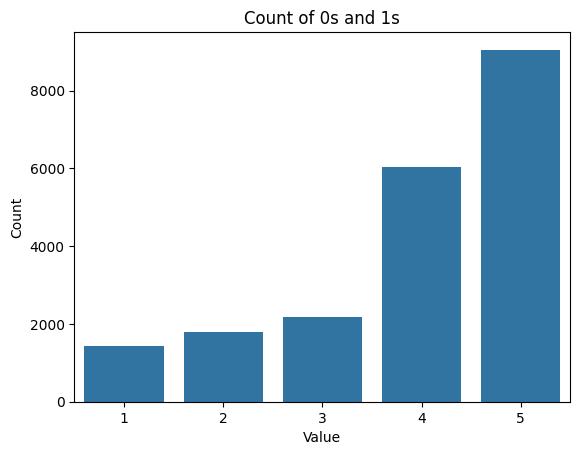

Rating
5    9054
4    6039
3    2184
2    1793
1    1421
Name: count, dtype: int64

In [4]:
sns.countplot(x=df['Rating'])
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Count of 0s and 1s')
plt.show()
counts = df['Rating'].value_counts()
counts

# Tokenizacja i trenowanie

In [ ]:
df = df[:4000]

In [ ]:
# Split into train/test/validation datasets - hmm dwa razy kod error
dataset = Dataset.from_pandas(df)

# Podział: 80% train, 10% validation, 10% test
train_test_split = dataset.train_test_split(test_size=0.2, seed=42, shuffle=True)
train_valid_split = train_test_split["test"].train_test_split(test_size=0.5, seed=42, shuffle=True)

# Create a new DatasetDict
dataset = DatasetDict({
    "train": train_test_split["train"],
    "validation": train_valid_split["train"],
    "test": train_valid_split["test"]
})

# Check dataset sizes
print(dataset)

In [ ]:
model = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model)

In [ ]:
def tokenize(batch):
    return tokenizer(batch["Review"], padding=True, truncation=True)

dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)
dataset_encoded

In [ ]:
dataset_encoded["train"].features

In [20]:
tf_model = (TFAutoModelForSequenceClassification.from_pretrained(model, num_labels=6))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [21]:
# The column names to convert to TensorFlow tensors
tokenizer_columns = tokenizer.model_input_names

# Define a batch size
batch_size = 64
lr = 5e-5
epochs = 2

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_dataset = dataset_encoded["train"].to_tf_dataset(columns=tokenizer_columns, 
                                                           label_cols=["Rating"], shuffle=True,
                                                           batch_size=batch_size,
                                                           collate_fn=data_collator)
tf_eval_dataset = dataset_encoded["validation"].to_tf_dataset(columns=tokenizer_columns, 
                                                               label_cols=["Rating"], shuffle=False,
                                                               batch_size=batch_size,
                                                               collate_fn=data_collator)

tf_train_dataset

C:\Users\sitko\anaconda3\envs\transformer\Lib\site-packages\datasets\arrow_dataset.py:405: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


<_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
start_time = time.time()

# optimization
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr * 0.1 if epoch % 10 == 0 else lr)
# Early stopping and saving the best model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)

tf_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=tf.metrics.SparseCategoricalAccuracy())

tf_model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=epochs, callbacks=[lr_scheduler])

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Execution time: {elapsed_time:.4f} seconds")

Epoch 1/2


In [ ]:
tf.keras.models.save_model(tf_model, filepath='my_model_kw', overwrite=True, save_format='tf')

In [95]:
Epoch 1/2
13/13 [==============================] - 2446s 187s/step - loss: 1.5735 - sparse_categorical_accuracy: 0.3375 - val_loss: 1.4097 - val_sparse_categorical_accuracy: 0.4000
Epoch 2/2
13/13 [==============================] - 2435s 186s/step - loss: 1.2820 - sparse_categorical_accuracy: 0.4812 - val_loss: 1.1416 - val_sparse_categorical_accuracy: 0.4800
Execution time: 4881.4054 seconds

SyntaxError: invalid decimal literal (1369303689.py, line 2)

loss, eval_accuracy = tf_model.evaluate(tf_eval_dataset)
print("Loss: {}\t Test Accuracy: {}".format(loss, eval_accuracy))

In [71]:
output_logits = tf_model.predict(tf_eval_dataset).logits
pred_labels = np.argmax(output_logits, axis=-1)

2/2 [==============================] - 20s 7s/step


Accuracy: 0.4800
Confusion Matrix:
[[ 6  0  0  1  0]
 [ 4  0  0  7  0]
 [ 1  0  0 15  0]
 [ 1  0  0 22 10]
 [ 0  0  0 13 20]]


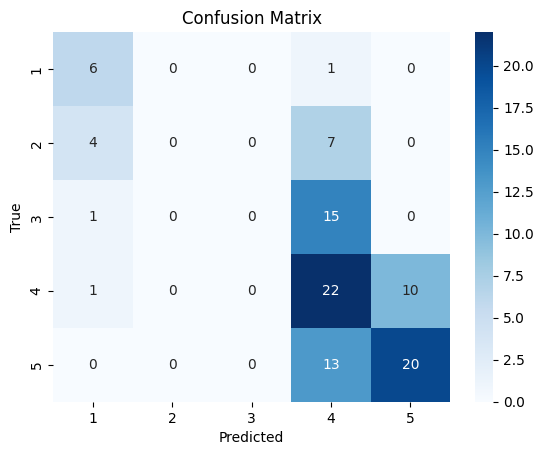

Classification Report:
              precision    recall  f1-score   support

           1       0.50      0.86      0.63         7
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00        16
           4       0.38      0.67      0.48        33
           5       0.67      0.61      0.63        33

    accuracy                           0.48       100
   macro avg       0.31      0.43      0.35       100
weighted avg       0.38      0.48      0.41       100



C:\Users\sitko\anaconda3\envs\transformer\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sitko\anaconda3\envs\transformer\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sitko\anaconda3\envs\transformer\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

In [93]:
dataset_encoded.set_format("pandas") 
cols = ["Review", "Rating"]
df_test = dataset_encoded["validation"][:][cols] 
df_test["Rating"]
df_test["predicted_label"] = pred_labels
df_test["predicted_label"] = df_test["predicted_label"]
# Ensure df_test contains the true labels and predicted labels
df_test["true_label"] = df_test["Rating"]

# Calculate Accuracy
accuracy = accuracy_score(df_test["true_label"], df_test["predicted_label"])
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(df_test["true_label"], df_test["predicted_label"])
print("Confusion Matrix:")
print(cm)

# Plot Confusion Matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(df_test["true_label"]), yticklabels=np.unique(df_test["true_label"]))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report (Precision, Recall, F1-score)
class_report = classification_report(df_test["true_label"], df_test["predicted_label"])
print("Classification Report:")
print(class_report)

In [89]:
def plot_cm(y_true, y_pred, figsize=(15, 15)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    
df_eval = pd.DataFrame({'y_true': y_valid, 'y_preds': y_preds})
df_eval['y_true'] = (df_eval['y_true'])
df_eval['y_preds'] = (df_eval['y_preds'])

NameError: name 'y_valid' is not defined

# stop

In [47]:
tf_model = TFAutoModel.from_pretrained(model)
tokenizer = AutoTokenizer.from_pretrained(model)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [55]:
# emotions_encoded.reset_format()

def extract_hidden_states(batch):
    # First convert text to tokens
    inputs = tokenizer(batch["comments"], padding=True, 
                       truncation=True, return_tensors='tf')
    # Extract last hidden states
    outputs = tf_model(inputs)
     # Return vector for [CLS] token
    return {"hidden_state": outputs.last_hidden_state[:,0].numpy()}

dataset_hidden = dataset_encoded.map(extract_hidden_states, batched=True, batch_size=64)

C:\Users\sitko\anaconda3\envs\transformer\Lib\site-packages\transformers\generation\tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

In [58]:
dataset_hidden

DatasetDict({
    train: Dataset({
        features: ['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 8
    })
    validation: Dataset({
        features: ['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 1
    })
    test: Dataset({
        features: ['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 1
    })
})

In [ ]:
X_train = np.array(dataset_hidden["train"]["hidden_state"])
X_valid = np.array(dataset_hidden["validation"]["hidden_state"])
y_train = np.array(dataset_hidden["train"]["label"])
y_valid = np.array(dataset_hidden["validation"]["label"])
X_train.shape, X_valid.shape

In [ ]:
# Outcome analysis 

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()